# 1. 강의영상 

{{<video https://youtu.be/playlist?list=PLQqh36zP38-wFUcEr7JtSb7MWUYl6QrW_&si=CmWA765p0mnwWTGA >}}

# 2. Imports 

In [8]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio

In [9]:
pd.options.plotting.backend = "plotly"
pio.templates.default = "plotly_white"

# 3. 데이터준비 

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/guebin/DV2023/main/posts/NYCTaxi.csv")
df_feature = df.assign(
    log_trip_duration = np.log(df.trip_duration),
    pickup_datetime = df.pickup_datetime.apply(pd.to_datetime),
    dropoff_datetime = df.dropoff_datetime.apply(pd.to_datetime),
    dist = np.sqrt((df.pickup_latitude-df.dropoff_latitude)**2 + (df.pickup_longitude-df.dropoff_longitude)**2),
    #---#
    vendor_id = df.vendor_id.map({1:'A',2:'B'})
).assign(
    speed = lambda df: df.dist / df.trip_duration,
    pickup_hour = lambda df: df.pickup_datetime.dt.hour,
    dropoff_hour = lambda df: df.dropoff_datetime.dt.hour,
    dayofweek = lambda df: df.pickup_datetime.dt.dayofweek
)

# 4. 시각화3 -- 애니메이션 

## A. scatter / (vendor_id,hour)

`-` 시각화 

In [4]:
fig = px.scatter_mapbox(
    data_frame=df_feature.sort_values('pickup_hour'),
    lat = 'pickup_latitude',
    lon = 'pickup_longitude',
    center = {'lat':40.7322, 'lon':-73.9052},
    color = 'vendor_id',
    size = 'passenger_count',
    size_max = 5,
    animation_frame = 'pickup_hour',
    #---#
    mapbox_style='carto-positron',
    zoom=10,
    width=750,
    height=600
)
fig.show(config={'scrollZoom': False})

- B가 전체적으로 동그라미가 큰것같지 않어..? 
- 시간대별로 확실히 빈도가 다르다

`-` 추가시각화1 -- `vendor_id`별 `passenger_count`를 barplot으로 시각화 

In [5]:
df_feature.groupby('vendor_id').agg({'passenger_count':'mean'})\
.reset_index()\
.plot.bar(y='vendor_id',x='passenger_count',color='vendor_id')

- B가 평균적으로 승객수가 더 많다. (B는 대형차량 위주로 빌려주는 회사인가?)

`-` 추가시각화2 -- `vendor_id`별 `passenger_count`를 boxplot으로 시각화 

In [6]:
df_feature.plot.box(x='vendor_id',y='passenger_count',color='vendor_id')

`-` 추가시각화3 -- `vendor_id`별 `passenger_count`를 histogram으로 시각화 

In [7]:
df_feature.plot.hist(x='passenger_count',color='vendor_id',facet_col='vendor_id')

- 1~4인 손님의 경우 A,B의 모양이 비슷한데, B는 5인 이상의 손님이 특이하게 많은 편이다. (B가 A에 비하여 1인손님이 좀 더 적고, 2인 손님은 좀 더 많긴함)

`-` 추가시각화4 -- `pickup_hour`별 `count`를 barplot으로 시각화 

In [8]:
df_feature.pickup_hour.value_counts().sort_index().plot.bar()

`-` 추가시각화5 -- (`pickup_hour`,`vendor_id`)별 `count`를 barplot으로 시각화 

In [9]:
df_feature.groupby(['vendor_id','pickup_hour']).size()\
.reset_index().rename({0:'count'},axis=1)\
.plot.bar(x='pickup_hour',y='count',color='vendor_id',facet_col='vendor_id')

`-` 추가시각화6 -- (`pickup_hour`,`vendor_id`)별 `count`를 areaplot으로 시각화 

In [10]:
df_feature.groupby(['vendor_id','pickup_hour']).size()\
.reset_index().rename({0:'count'},axis=1)\
.plot.area(x='pickup_hour',y='count',color='vendor_id')

`-` 추가시각화7 -- (`pickup_hour`,`vendor_id`)별 `count`를 lineplot으로 시각화 

In [11]:
df_feature.groupby(['vendor_id','pickup_hour']).size()\
.reset_index().rename({0:'count'},axis=1)\
.plot.line(x='pickup_hour',y='count',color='vendor_id')

## B. scatter / (vendor_id,day_of_week)

In [12]:
fig = px.scatter_mapbox(
    data_frame=df_feature.sort_values('dayofweek'),
    lat = 'pickup_latitude',
    lon = 'pickup_longitude',
    center = {'lat':40.7322, 'lon':-73.9052},
    color = 'vendor_id',
    size = 'passenger_count',
    size_max = 5,
    animation_frame = 'dayofweek',
    #---#
    mapbox_style='carto-positron',
    zoom=10,
    width=750,
    height=600
)
fig.show(config={'scrollZoom': False})

- 생각보다 요일별 특징은 그다지 뚜렷하지 않음

# 5. 시각화4 -- `heatmap`

## A. (요일,시간)에 따른 `count` 시각화 

In [13]:
tidydata = df_feature.pivot_table(
    index = 'pickup_hour',
    columns = 'dayofweek',
    aggfunc='size'
).stack().reset_index().rename({0:'count'},axis=1)
#---# 
px.density_heatmap(
    data_frame=tidydata,
    x='pickup_hour',
    y='dayofweek',
    z='count',
    nbinsx=24,
    nbinsy=7,
    height=300,
)

- 노란색: 불금? 피크타임?

## B. (요일,시간)에 따른 `dist` 시각화

In [15]:
tidydata = df_feature.pivot_table(
    index = 'pickup_hour',
    columns = 'dayofweek',
    values = 'dist',
    aggfunc='mean'
).stack().reset_index().rename({0:'dist'},axis=1)
#---# 
px.density_heatmap(
    data_frame=tidydata,
    x='pickup_hour',
    y='dayofweek',
    z='dist',
    nbinsx=24,
    nbinsy=7,
    height=300,
)

- 노란색: 일요일 아침부터 장거리.. (관광객? 공항가는 사람일까? 놀러가는 사람일까?)

## C. (요일,시간)에 따른 `speed` 시각화

In [16]:
tidydata = df_feature.pivot_table(
    index = 'pickup_hour',
    columns = 'dayofweek',
    values = 'speed',
    aggfunc='mean'
).stack().reset_index().rename({0:'speed'},axis=1)
#---# 
px.density_heatmap(
    data_frame=tidydata,
    x='pickup_hour',
    y='dayofweek',
    z='speed',
    nbinsx=24,
    nbinsy=7,
    height=300
)

- 남색 = 교통체증이 심한 곳 

# 6. 시각화5 -- 경로시각화 

`-` 이거는 너무 무거워서 좀 작은 데이터로 실습합니다. 

In [17]:
df_feature_small = df_feature[::100].reset_index(drop=True)

## A. 예비학습 

`-` 경로그리기 

In [27]:
df_sample = pd.DataFrame(
    {'path':['A','A','B','B','B'],
     'lon':[-73.986420,-73.995300,-73.975922,-73.988922,-73.962654],
     'lat':[40.756569,40.740059,40.754192,40.762859,40.772449]}
)

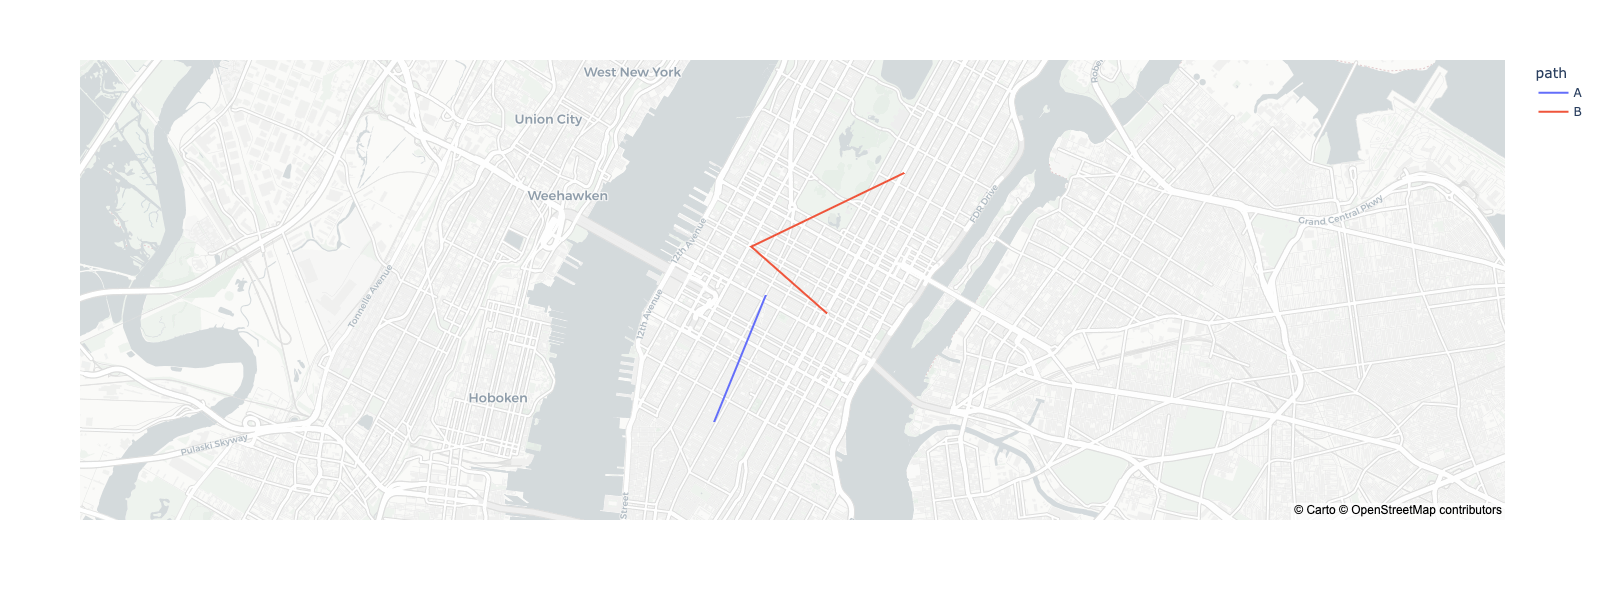

In [28]:
fig = px.line_mapbox(
    data_frame=df_sample,
    lat="lat", 
    lon="lon", 
    line_group = 'path',
    color='path',
    #---#
    mapbox_style='carto-positron',
    zoom=12,
    width=750,
    height=600,
)
fig.show(config={'scrollZoom': False})

`-` 산점도로 그리기 

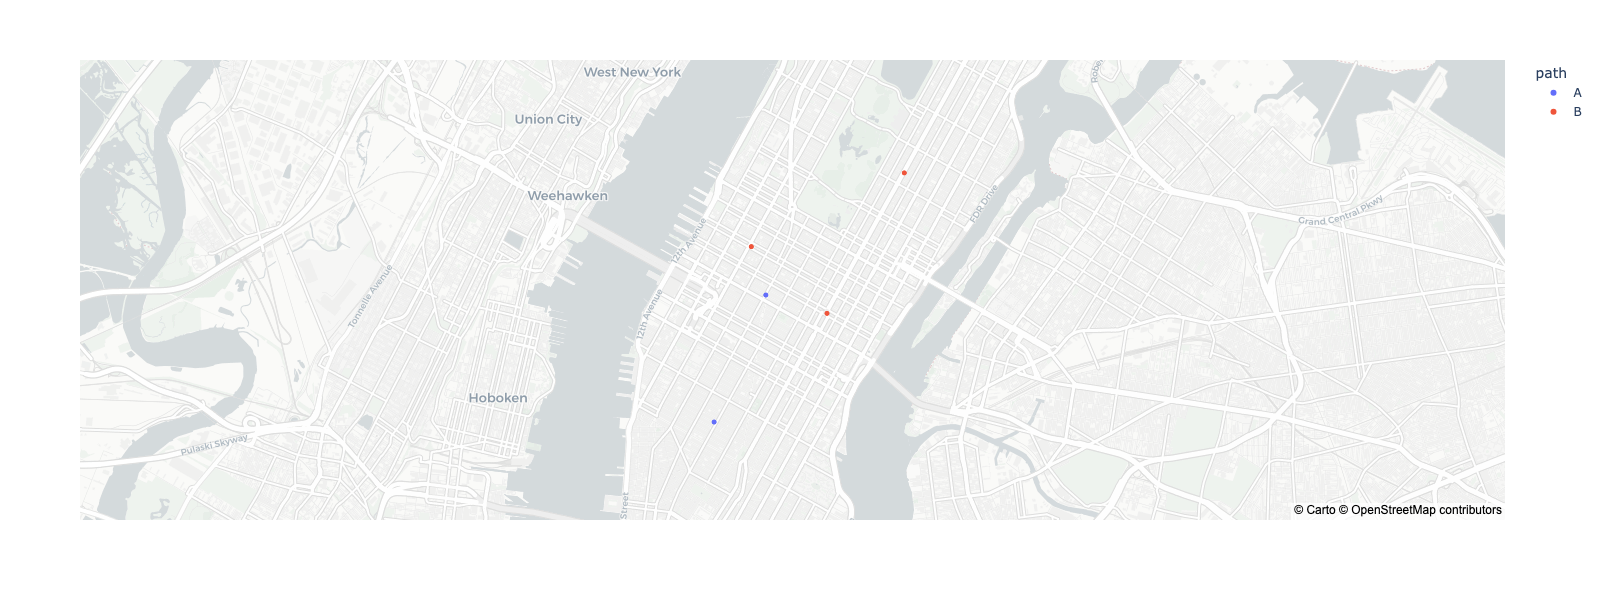

In [30]:
_fig = px.scatter_mapbox(
    data_frame=df_sample,
    lat="lat", 
    lon="lon", 
    color='path',
    #---#
    mapbox_style='carto-positron',
    zoom=12,
    width=750,
    height=600,
)
_fig.show(config={'scrollZoom': False})

`-` 합치기 

In [33]:
_fig.data

(Scattermapbox({
     'hovertemplate': 'path=A<br>lat=%{lat}<br>lon=%{lon}<extra></extra>',
     'lat': array([40.756569, 40.740059]),
     'legendgroup': 'A',
     'lon': array([-73.98642, -73.9953 ]),
     'marker': {'color': '#636efa'},
     'mode': 'markers',
     'name': 'A',
     'showlegend': True,
     'subplot': 'mapbox'
 }),
 Scattermapbox({
     'hovertemplate': 'path=B<br>lat=%{lat}<br>lon=%{lon}<extra></extra>',
     'lat': array([40.754192, 40.762859, 40.772449]),
     'legendgroup': 'B',
     'lon': array([-73.975922, -73.988922, -73.962654]),
     'marker': {'color': '#EF553B'},
     'mode': 'markers',
     'name': 'B',
     'showlegend': True,
     'subplot': 'mapbox'
 }))

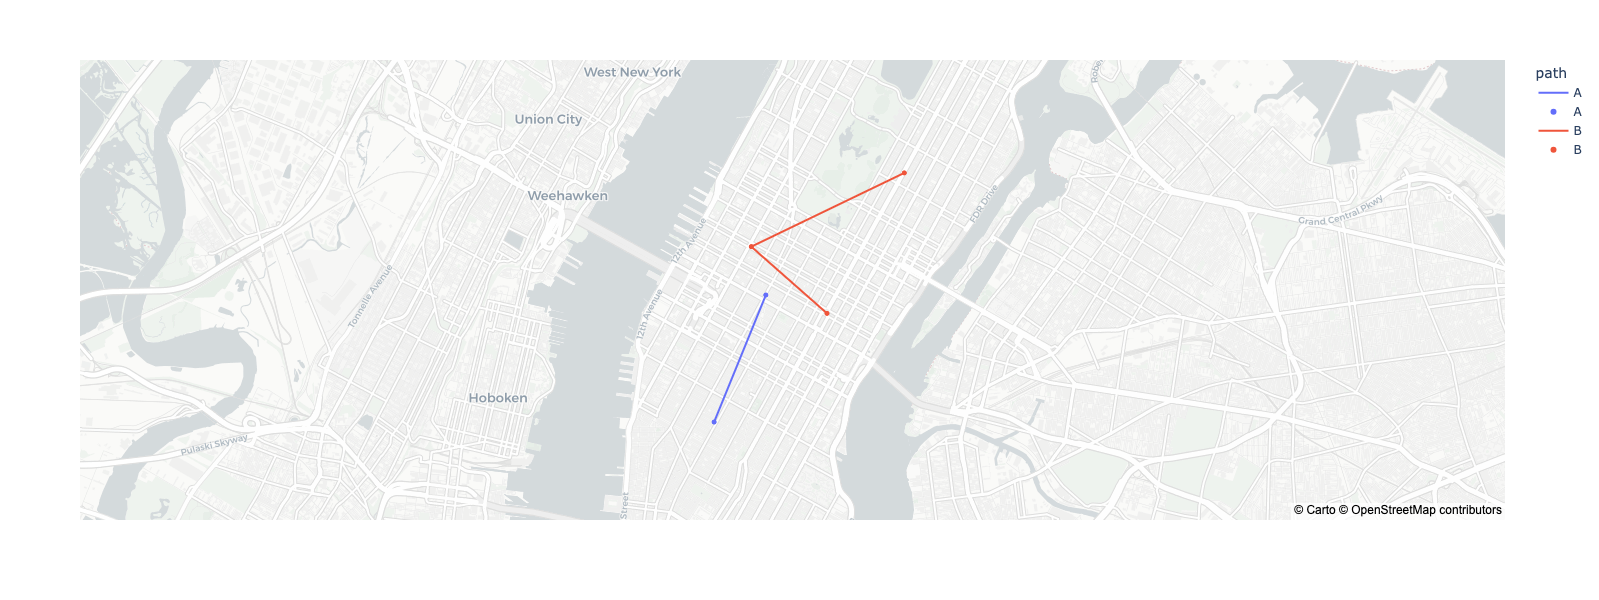

In [37]:
fig = px.line_mapbox(
    data_frame=df_sample,
    lat="lat", 
    lon="lon", 
    line_group = 'path',
    color='path',
    #---#
    mapbox_style='carto-positron',
    zoom=12,
    width=750,
    height=600,
)
fig.add_trace(_fig.data[0])
fig.add_trace(_fig.data[1])
fig.show(config={'scrollZoom': False})

## B. 전처리

In [18]:
pcols = ['pickup_datetime','pickup_longitude','pickup_latitude']
dcols = ['dropoff_datetime','dropoff_longitude','dropoff_latitude']

In [19]:
def transform(df):
    pick_up = df.loc[:,['id']+pcols].set_axis(['id','datetime','lon','lat'],axis=1).eval('state = "pickup"')
    drop_off = df.loc[:,['id']+dcols].set_axis(['id','datetime','lon','lat'],axis=1).eval('state = "dropoff"')
    return pd.concat([pick_up,drop_off],axis=0).reset_index(drop=True)

In [20]:
df_left = pd.concat([transform(df) for i,df in df_feature_small.groupby('id')]).reset_index(drop=True)
df_right = df_feature_small.drop(pcols+dcols,axis=1)
df_feature_small2 = pd.merge(df_left,df_right)

In [21]:
df_feature_small2

id            datetime        lon        lat    state vendor_id  \
0    id0037819 2016-05-16 17:42:32 -73.986420  40.756569   pickup         B   
1    id0037819 2016-05-16 17:47:05 -73.995300  40.740059  dropoff         B   
2    id0049607 2016-03-13 18:48:49 -73.975922  40.754192   pickup         A   
3    id0049607 2016-03-13 18:56:08 -73.988922  40.762859  dropoff         A   
4    id0051866 2016-01-04 18:48:12 -73.962654  40.772449   pickup         A   
..         ...                 ...        ...        ...      ...       ...   
287  id3825370 2016-05-08 17:36:48 -73.979195  40.669765  dropoff         A   
288  id3888107 2016-06-21 18:30:05 -73.969429  40.757469   pickup         B   
289  id3888107 2016-06-21 18:44:43 -73.982742  40.771969  dropoff         B   
290  id3988208 2016-03-01 21:40:13 -73.948929  40.797405   pickup         A   
291  id3988208 2016-03-01 21:47:26 -73.967438  40.789543  dropoff         A   

     passenger_count store_and_fwd_flag  trip_duration  log_trip_duration  \
0                  6                  N            273           5.609472   
1                  6                  N            273           5.609472   
2                  2                  N            439           6.084499   
3                  2                  N            439           6.084499   
4                  1                  N            638           6.458338   
..               ...                ...            ...                ...   
287                4                  N           2358           7.765569   
288                1                  N            878           6.777647   
289                1                  N            878           6.777647   
290                1                  N            433           6.070738   
291                1                  N            433           6.070738   

         dist     speed  pickup_hour  dropoff_hour  dayofweek  
0    0.018747  0.000069           17            17          0  
1    0.018747  0.000069           17            17          0  
2    0.015625  0.000036           18            18          6  
3    0.015625  0.000036           18            18          6  
4    0.022953  0.000036           18            18          0  
..        ...       ...          ...           ...        ...  
287  0.084519  0.000036           16            17          6  
288  0.019685  0.000022           18            18          1  
289  0.019685  0.000022           18            18          1  
290  0.020110  0.000046           21            21          1  
291  0.020110  0.000046           21            21          1  

[292 rows x 15 columns]

## C. `vendor_id` 별 시각화 

In [22]:
fig = px.line_mapbox(
    data_frame=df_feature_small2,
    lat="lat", 
    lon="lon", 
    center = {'lat':40.7322, 'lon':-73.9052},
    line_group = 'id',
    color='vendor_id',
    #---#
    mapbox_style='carto-positron',
    zoom=10,
    width=750,
    height=600,
)
trace_data = px.scatter_mapbox(
        data_frame=df_feature_small2,
        lat = 'lat',
        lon = 'lon',
        center = {'lat':40.7322, 'lon':-73.9052},
        color = 'vendor_id',
        size = 'trip_duration',
        size_max = 10,
).data
for d in trace_data: 
    fig.add_trace(d)
fig.update_traces(
    line={
        'width':1,
    },
    opacity=0.8
)
fig.show(config={'scrollZoom': False})

## D. `dayofweek`별 시각화 

In [23]:
tidydata = df_feature_small2.assign(dayofweek=lambda df: df.dayofweek.astype(str)).sort_values('dayofweek')

fig = px.line_mapbox(
    data_frame=tidydata,
    lat="lat", 
    lon="lon", 
    center = {'lat':40.7322, 'lon':-73.9052},
    line_group = 'id',
    color='dayofweek',
    #---#
    mapbox_style='carto-positron',
    zoom=10,
    width=750,
    height=600,
)
trace_data = px.scatter_mapbox(
        data_frame=tidydata,
        lat = 'lat',
        lon = 'lon',
        center = {'lat':40.7322, 'lon':-73.9052},
        color = 'dayofweek',
        size = 'trip_duration',
        size_max = 10,
).data
for d in trace_data: 
    fig.add_trace(d)
fig.update_traces(
    line={
        'width':1,
    },
    opacity=0.8
)
fig.show(config={'scrollZoom': False})

## E. `speed`별 시각화 

In [24]:
df_feature_small2.assign(
    speed_cut = lambda df: pd.qcut(df.speed,4)
)

id            datetime        lon        lat    state vendor_id  \
0    id0037819 2016-05-16 17:42:32 -73.986420  40.756569   pickup         B   
1    id0037819 2016-05-16 17:47:05 -73.995300  40.740059  dropoff         B   
2    id0049607 2016-03-13 18:48:49 -73.975922  40.754192   pickup         A   
3    id0049607 2016-03-13 18:56:08 -73.988922  40.762859  dropoff         A   
4    id0051866 2016-01-04 18:48:12 -73.962654  40.772449   pickup         A   
..         ...                 ...        ...        ...      ...       ...   
287  id3825370 2016-05-08 17:36:48 -73.979195  40.669765  dropoff         A   
288  id3888107 2016-06-21 18:30:05 -73.969429  40.757469   pickup         B   
289  id3888107 2016-06-21 18:44:43 -73.982742  40.771969  dropoff         B   
290  id3988208 2016-03-01 21:40:13 -73.948929  40.797405   pickup         A   
291  id3988208 2016-03-01 21:47:26 -73.967438  40.789543  dropoff         A   

     passenger_count store_and_fwd_flag  trip_duration  log_trip_duration  \
0                  6                  N            273           5.609472   
1                  6                  N            273           5.609472   
2                  2                  N            439           6.084499   
3                  2                  N            439           6.084499   
4                  1                  N            638           6.458338   
..               ...                ...            ...                ...   
287                4                  N           2358           7.765569   
288                1                  N            878           6.777647   
289                1                  N            878           6.777647   
290                1                  N            433           6.070738   
291                1                  N            433           6.070738   

         dist     speed  pickup_hour  dropoff_hour  dayofweek  \
0    0.018747  0.000069           17            17          0   
1    0.018747  0.000069           17            17          0   
2    0.015625  0.000036           18            18          6   
3    0.015625  0.000036           18            18          6   
4    0.022953  0.000036           18            18          0   
..        ...       ...          ...           ...        ...   
287  0.084519  0.000036           16            17          6   
288  0.019685  0.000022           18            18          1   
289  0.019685  0.000022           18            18          1   
290  0.020110  0.000046           21            21          1   
291  0.020110  0.000046           21            21          1   

                speed_cut  
0    (4.78e-05, 0.000109]  
1    (4.78e-05, 0.000109]  
2    (2.63e-05, 3.63e-05]  
3    (2.63e-05, 3.63e-05]  
4    (2.63e-05, 3.63e-05]  
..                    ...  
287  (2.63e-05, 3.63e-05]  
288    (-0.001, 2.63e-05]  
289    (-0.001, 2.63e-05]  
290  (3.63e-05, 4.78e-05]  
291  (3.63e-05, 4.78e-05]  

[292 rows x 16 columns]

In [25]:
tidydata = df_feature_small2.assign(
    speed_cut = lambda df: pd.qcut(df.speed,4)
).sort_values('speed_cut')
fig = px.line_mapbox(
    data_frame=tidydata,
    lat="lat", 
    lon="lon", 
    center = {'lat':40.7322, 'lon':-73.9052},
    line_group = 'id',
    color='speed_cut',
    #---#
    mapbox_style='carto-positron',
    zoom=10,
    width=750,
    height=600,
)
trace_data = px.scatter_mapbox(
        data_frame=tidydata,
        lat = 'lat',
        lon = 'lon',
        center = {'lat':40.7322, 'lon':-73.9052},
        color = 'speed_cut',
        size = 'trip_duration',
        size_max = 10,
).data
for d in trace_data: 
    fig.add_trace(d)
fig.update_traces(
    line={
        'width':1,
    },
    opacity=0.8
)
fig.show(config={'scrollZoom': False})

/home/cgb2/anaconda3/envs/ag/lib/python3.10/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/home/cgb2/anaconda3/envs/ag/lib/python3.10/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

